In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import numpy as np
import itertools
sns.set(context='talk')

In [6]:
def bootstrap_gen(dataframe):
    return dataframe.sample(frac=1,replace=True)
def CVratio(experimentdata):
    return (experimentdata["<y>"].std(ddof=0)/experimentdata["<y>"].mean())/(experimentdata["<x>"].std(ddof=0)/experimentdata["<x>"].mean())
def xycorr(experimentdata):
    return experimentdata["<x>"].corr(experimentdata["<y>"])
def bootstrap_stderr_mean(experimentdata,f,n):
    bootstrap_fs = [f(bootstrap_gen(experimentdata)) for i in range(n)]
    return np.std(bootstrap_fs,ddof=0)/np.sqrt(len(experimentdata)),np.mean(bootstrap_fs)
def joinedbootstrap(experimentdata,n):
    rhos = []
    Cs = []
    for i in range(n):
        sample = bootstrap_gen(experimentdata)
        rhos.append(xycorr(sample))
        Cs.append(CVratio(sample))
    return np.std(Cs)/np.sqrt(len(experimentdata)),np.std(rhos)/np.sqrt(len(experimentdata))


files = glob.glob('no_fb_sims_largerange4_2023-02-02/*_simresults.tsv')
dfs = list()
for f in files:
    data = pd.read_csv(f,sep='\t')
    data['file'] = f
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [7]:
folders = glob.glob('samplingdist_test*')
df = pd.DataFrame()
for i,folder in enumerate(folders):
    files = glob.glob(folder+'/*_simresults.tsv')
    for f in files:
        data = pd.read_csv(f,sep='\t')
        simsettings = pd.read_csv(f[:-14]+'settings.tsv',sep='\t')
        simsettings = simsettings.drop(['cov thres','flux thres'],axis=1)
        data = pd.concat([data,simsettings.loc[simsettings.index.repeat(len(data))].reset_index(drop=True)],axis=1)
        data["file"] = f
        data['covcheck'] = data['cov thres'].apply(lambda x: all(float(i) <= 0.05 for i in x.strip('[]').split(',')))
        data['usedparams'] =  data['usedparams'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split(',')]))
        df = pd.concat([df,data],ignore_index=True)


In [8]:
cols = ["file","C","rho","std_rho","std_C","covcheck","numsims","glcov","etaxx"]
pertdata = pd.DataFrame(columns=cols)
for f in df['file'].unique():
    #isolate data by parameter set
    experimentdata = df[df["file"] == f]
    #Total sims in the point
    nsims = len(experimentdata)
    #number of sims in data that didn't reach cov balance
    ncov = len(experimentdata[experimentdata["covcheck"]==False])
    #calculate quantity
    rho = xycorr(experimentdata)
    C_val = CVratio(experimentdata)
    #estimate standard error by bootstrapping
    std_Cval,std_rho = joinedbootstrap(experimentdata,10000)
    glcov = np.cov(np.stack(experimentdata['usedparams'].to_numpy()),rowvar=False)[0,2]
    means = np.mean(np.stack(experimentdata['usedparams'].to_numpy()),axis=0)
    denom = (experimentdata["<x>"].std()/(experimentdata["<x>"].mean()))**2
    
    df2 = pd.DataFrame([[f,C_val,rho,std_rho,std_Cval,ncov,nsims,glcov/(means[0]*means[2]),denom]], columns= cols)
    pertdata = pd.concat([pertdata,df2])

In [9]:
pertdata

,file,C,rho,std_rho,std_C,covcheck,numsims,glcov,etaxx
0,samplingdist_test_2023-Feb13_1545/pertset_2_pa...,1.4271,0.715921,0.012054,0.020681,0,40,0.000498,0.012131
0,samplingdist_test_2023-Feb13_1545/pertset_2_pa...,1.434143,0.717179,0.011821,0.020916,0,40,0.000498,0.012055
0,samplingdist_test_2023-Feb13_1545/pertset_1_pa...,1.259644,0.666823,0.012522,0.018639,0,40,-0.000684,0.003962
0,samplingdist_test_2023-Feb13_1545/pertset_3_pa...,1.422591,0.748966,0.00902,0.023012,0,40,0.00223,0.032836
0,samplingdist_test_2023-Feb13_1545/pertset_3_pa...,1.41813,0.749505,0.009084,0.022966,0,40,0.00223,0.032986
0,samplingdist_test_2023-Feb13_1545/pertset_1_pa...,1.251671,0.667903,0.012157,0.018704,0,40,-0.000684,0.004012
0,samplingdist_test_2023-Feb13_1719/pertset_2_pa...,1.518268,0.695059,0.01173,0.023345,0,40,0.000594,0.011976
0,samplingdist_test_2023-Feb13_1719/pertset_2_pa...,1.524904,0.696838,0.011699,0.023481,0,40,0.000594,0.01188
0,samplingdist_test_2023-Feb13_1719/pertset_1_pa...,1.44574,0.685837,0.012596,0.021561,0,40,-0.000094,0.003124
0,samplingdist_test_2023-Feb13_1719/pertset_3_pa...,1.439943,0.733261,0.010629,0.022419,0,40,0.001985,0.03134


All of the points, regardless if good or not

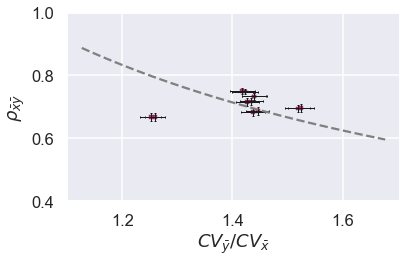

In [18]:
plotted = pertdata[(pertdata['covcheck']==0)&(pertdata['numsims']>9)]
f2,ax2 = plt.subplots()
ax2.set(ylim=(0.4,1),xlabel=r"$CV_{\bar{y}}/CV_{\bar{x}} $",ylabel=r"$\rho_{\bar{x} \bar{y}}$")
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=1,data=plotted, label=None, capsize=1, capthick=1,color='k',fmt='none')
plt.plot(np.linspace(0.9*plotted["C"].min(),(1.1)*plotted["C"].max()),1/np.linspace(0.9*plotted["C"].min(),(1.1)*plotted["C"].max()),'--',color='gray')
sns.scatterplot(data=plotted,x="C",y="rho",hue='covcheck',
                alpha=1,edgecolor='k',legend=False,
                marker='s',palette=['#DC267F'],s=15)
plt.tight_layout()
plt.savefig("nofbsims_sampling.svg",transparent=True)

Correction for calcualted covariance

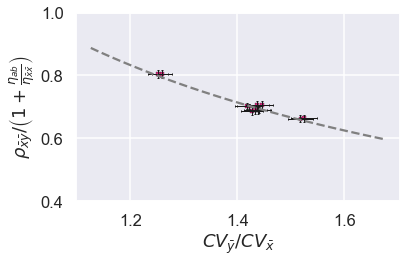

In [21]:
pertdata['rho/(1+glcov/etaxx)'] = pertdata['rho']/(1+(pertdata['glcov']/pertdata['etaxx']))
plotted = pertdata[(pertdata['covcheck']==0)&(pertdata['numsims']>9)]
f2,ax2 = plt.subplots()
ax2.set(ylim=(0.4,1),xlabel=r"$CV_{\bar{y}}/CV_{\bar{x}} $",ylabel=r"$\rho_{\bar{x} \bar{y}}/\left(1+\frac{\eta_{ab}}{\eta_{\bar{x}\bar{x}}} \right)$")
plt.errorbar(y='rho/(1+glcov/etaxx)', x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=1,data=plotted, label=None, capsize=1, capthick=1,color='k',fmt='none')
plt.plot(np.linspace(0.9*plotted["C"].min(),(1.1)*plotted["C"].max()),1/np.linspace(0.9*plotted["C"].min(),(1.1)*plotted["C"].max()),'--',color='gray')
sns.scatterplot(data=plotted,x="C",y='rho/(1+glcov/etaxx)',hue='covcheck',
                alpha=1,edgecolor='k',
                marker='s',palette=['#DC267F'],s=15,legend=False)
plt.tight_layout()
plt.savefig("nofbsims_sampling_corrected.svg",transparent=True)

just points where all sims passed covcheck

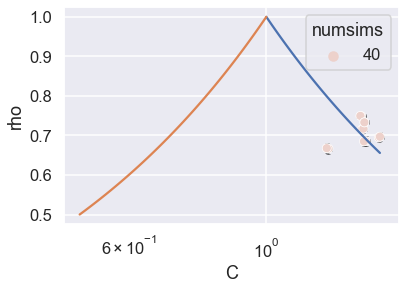

In [12]:
cleared = pertdata[pertdata["covcheck"]==0]
sns.scatterplot(data=cleared,x="C",y="rho",hue='numsims')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=cleared, label=None, capsize=2, capthick=0.5,color='k',fmt='none',zorder=-1)
plt.plot(np.linspace(1,cleared["C"].max()),1/np.linspace(1,cleared["C"].max()))
plt.plot(np.linspace(0.5,1),np.linspace(0.5,1))
plt.xscale('log')